In [1]:
!pip install transformers accelerate opencv-python pillow matplotlib

   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   --------------- ------------------------ 3.9/10.4 MB 23.5 MB/s eta 0:00:01
   ---------------------------------- ----- 8.9/10.4 MB 25.2 MB/s eta 0:00:01
   ---------------------------------------- 10.4/10.4 MB 24.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 34.5 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Tue May  6 00:11:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.61                 Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P3             22W /   45W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import torch
from transformers import (
    BlipProcessor, BlipForConditionalGeneration,
    AutoTokenizer, AutoModelForCausalLM
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔌 Using device: {device}")

# Load BLIP
blip_model_id = "Salesforce/blip-image-captioning-base"
blip_processor = BlipProcessor.from_pretrained(blip_model_id)
blip_model = BlipForConditionalGeneration.from_pretrained(blip_model_id).to(device)

# Load Phi-2
phi_model_id = "microsoft/phi-2"
phi_tokenizer = AutoTokenizer.from_pretrained(phi_model_id)
phi_model = AutoModelForCausalLM.from_pretrained(phi_model_id).to(device)

print("✅ Models loaded.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


🔌 Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Models loaded.


In [19]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time

def analyze_fire_image(image_path):
    # Load and convert image
    bgr_image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_image)

    # Show image
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.title(image_path)
    plt.show()

    times = {}

    # Step 1: BLIP captioning
    t0 = time.time()
    inputs = blip_processor(pil_image, return_tensors="pt").to(device)
    with torch.no_grad():
        output = blip_model.generate(**inputs)
    caption = blip_processor.decode(output[0], skip_special_tokens=True)
    times['blip'] = round(time.time() - t0, 3)

    # Step 2: Phi-2 classification
    prompt = f"""You are an emergency advisor. Based on the image caption, classify the fire situation into one of three categories and give brief advice.

      Categories:
      🔵 Harmless – No cause for concern.
      🟡 Controlled – Supervised fire, but stay alert.
      🔴 Dangerous – Uncontrolled fire. Call emergency services.

      Examples:

      Caption: A person is lighting a matchstick.
      Response: 🔵 Harmless. No action needed.

      Caption: Flames are rising from a pile of trash on the sidewalk.
      Response: 🔴 Dangerous. Call emergency services immediately.

      Caption: A campfire is burning at night with people sitting around it.
      Response: 🟡 Controlled. Monitor closely.

      Caption: A fire has broken out in a kitchen and is spreading.
      Response: 🔴 Dangerous. Call emergency services immediately.

      Caption: A cozy fireplace inside a living room with no visible flames outside the fireplace.
      Response: 🔵 Harmless. No action needed.

      Caption: Smoke and flames are coming from windows of an apartment building.
      Response: 🔴 Dangerous. Call emergency services immediately.

      Caption: A barbecue grill with flames under control in a backyard.
      Response: 🟡 Controlled. Monitor closely.

      Caption: {caption}
      Response:"""


    t1 = time.time()
    phi_inputs = phi_tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        phi_output = phi_model.generate(**phi_inputs, max_new_tokens=50)
    response_text = (
        phi_tokenizer.decode(phi_output[0], skip_special_tokens=True)
        .split("Response:")[-1]
        .strip()
        .split("\n")[0]
        .strip('"""')
    )
    times['phi'] = round(time.time() - t1, 3)
    total_elapsed_time = round(time.time() - t0, 3)

    print(f"Image Desciption: {caption}")
    print(f"BLIP Response Time: {times['blip']}s\n")
    print(f"Advice: {response_text}")
    print(f"Phi-2 Response Time: {times['phi']}s\n")
    print(f"Total Elpased Time: {total_elapsed_time}s")

    return caption, response_text, times


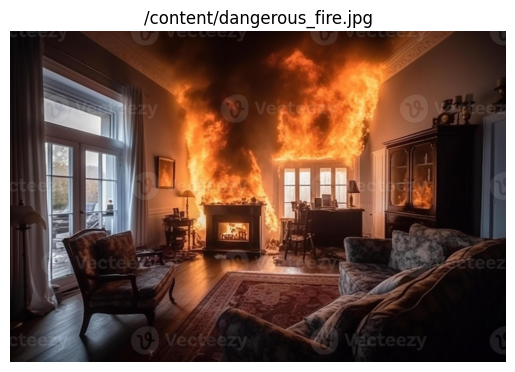

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Image Desciption: a living room with a fire burning in the ceiling
BLIP Response Time: 0.456s

Advice: 🔴 Dangerous. Call emergency services immediately.
Phi-2 Response Time: 2.954s
Total Elpased Time: 3.409s


In [20]:
image_path = "/content/dangerous_fire.jpg"

caption, advice, times = analyze_fire_image(image_path)

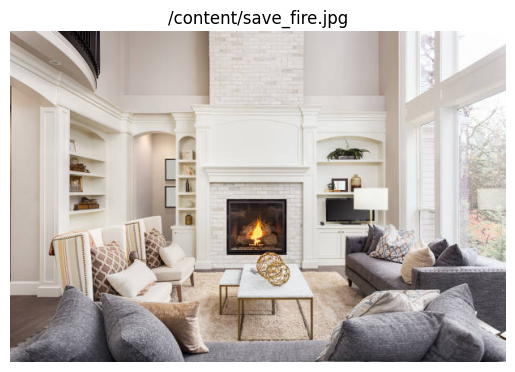

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Image Desciption: a living room with a fireplace and couches
BLIP Response Time: 0.246s

Advice: 🔵 Harmless. No action needed.
Phi-2 Response Time: 2.973s
Total Elpased Time: 3.22s


In [21]:
image_path = "/content/save_fire.jpg"

caption, advice, times = analyze_fire_image(image_path)